In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import os
import sys
import itertools
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
project_root = os.path.abspath(os.getcwd())

data_dir = os.path.join(os.path.dirname(project_root))

results_dir = os.path.join(data_dir, 'results')

figures_dir = os.path.join(data_dir, 'figures')

# Summer month

results_basecase_summer = pd.read_csv(os.path.join(results_dir, 'results_basecase_summer.csv'),sep=',')
#results_basecase_winter = pd.read_csv(os.path.join(results_dir, 'results_basecase_winter.csv'), sep=',')
#results_case_1_winter = pd.read_csv(os.path.join(results_dir, 'results_case_1_winter.csv'), sep=',')
#results_case_2_summer = pd.read_csv(os.path.join(results_dir,'results_case_2_summer.csv'), sep=',')
#results_case_2_winter = pd.read_csv(os.path.join(results_dir,'results_case_2_winter.csv'), sep=',')
#results_case_3_winter = pd.read_csv(os.path.join(results_dir,'results_case_3_winter.csv'), sep=',')
#results_case_3_summer = pd.read_csv(os.path.join(data_dir,'results_case_3_summer.csv'), sep=',')


In [45]:
#print column names of all the dfs
#print('results_basecase_summer' , results_basecase_summer.head())
#print('results_case_2_summer' , results_case_2_summer.columns)
#print('results_case_3_summer' , results_case_3_summer.columns)#

In [45]:
import matplotlib.dates as mdates

def plot_energy_profile(
    results_df,
    title="Energy Profile",
    save_filename="energy_profile.png",
    max_time=24 * 7,  # Default to one week
    min_time=0,
    power_dishwasher=1.5,
    power_wm=3,
    power_dryer=3,):

    # Ensure timestamp column is in datetime format
    results_df['timestamp'] = pd.to_datetime(results_df['timestamp'])
    timestamps = results_df['timestamp'][min_time:max_time]
    time_range = range(min_time, max_time)

    sns.set_theme(style="whitegrid")
    
    # Extract relevant signals

    binary_dishwasher = results_df['Dishwasher_On']
    binary_wm = results_df['Washing_Machine_On']
    binary_dryer = results_df['Dryer_On']
    soc_ev = results_df['EV_SOC']
    spot_price = results_df['Spotmarket_(EUR/kWh)']
    inflex_demand = results_df['Inflexible_Demand_(kWh)']
    charging_ev = results_df['EV_Charging']
    
    # Build power demand DataFrame
    data_power = pd.DataFrame({
        'timestamp': timestamps,
        'Inflexible Demand': [inflex_demand[t] for t in time_range],
        'Dishwasher': [power_dishwasher * binary_dishwasher[t] for t in time_range],
        'Washing Machine': [power_wm * binary_wm[t] for t in time_range],
        'Dryer': [power_dryer * binary_dryer[t] for t in time_range],
        'EV Charging': [charging_ev[t] for t in time_range]
    })

    if "Heatpump_Power" in results_df.columns:
        data_power['Heat Pump'] = [results_df["Heatpump_Power"][t] for t in time_range]

    data_power_melted = data_power.melt(id_vars='timestamp', var_name='Technology', value_name='Power (kWh)')
    palette = sns.color_palette("tab10", n_colors=len(data_power_melted['Technology'].unique()))

    plt.rcParams.update({
        'axes.titlesize': 16,
        'axes.labelsize': 13,
        'legend.fontsize': 13,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11
    })

    fig, ax1 = plt.subplots(figsize=(10, 7))
    sns.lineplot(data=data_power_melted, x='timestamp', y='Power (kWh)', hue='Technology', ax=ax1, palette=palette, drawstyle='steps-post')

    ax1.set_ylabel("Hourly Energy Demand (kWh)")
    ax1.set_xlabel("Day")
    ax1.set_xlim(timestamps.iloc[0].normalize(), timestamps.iloc[-1].normalize() + pd.Timedelta(days=1))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%a %d.%m'))
    ax1.xaxis.set_major_locator(mdates.DayLocator())

    # Spotmarket price
    ax2 = ax1.twinx()
    ax2.plot(timestamps, spot_price[min_time:max_time], '--', color='#a52a2a', label='Spotmarket Price')
    ax2.set_ylabel("Spotmarket Price (EUR/kWh)", color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # EV SOC
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.plot(timestamps, soc_ev[min_time:max_time] / 70, 'g:', label='EV SOC')
    ax3.set_ylabel("EV SOC", color='black')
    ax3.tick_params(axis='y', labelcolor='black')
    ax3.set_ylim(0, 1)

    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()

    legend = ax1.legend(
        lines1 + lines2 + lines3,
        labels1 + labels2 + labels3,
        loc='upper right',
        fontsize=9,
        labelspacing=0.3,
        borderpad=0.3,
        handlelength=1.2,
        handletextpad=0.4,
        borderaxespad=0.5,
        fancybox=True,
        facecolor='#f9f9f9',
    )
    legend.get_frame().set_alpha(0.9)

    plt.title(title)
    plt.tight_layout()
    ax1.grid(False)
    ax2.grid(False)
    ax3.grid(False)

    plt.savefig(os.path.join(figures_dir, save_filename), dpi=400, bbox_inches='tight')
    plt.show()
  

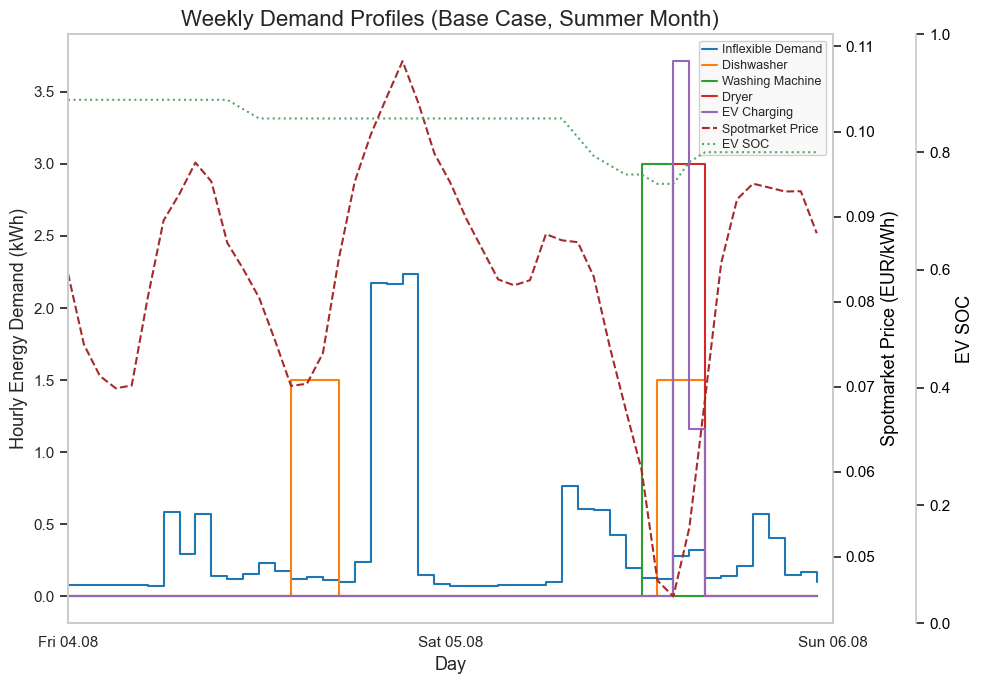

In [46]:
plot_title = "Weekly Demand Profiles (Base Case, Summer Month)"

filename = "basecase_summer.png"

start_day = 3
end_day = 5

plot_energy_profile(
    results_df=results_basecase_summer,
    title=plot_title,
    save_filename= filename,
    max_time=24 * end_day,
    min_time=24 * start_day,
)

In [60]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import os

def plot_energy_profiles_comparison(
    results_list,
    titles,
    labels=None,
    save_filename="comparison_plot.png",
    min_time=0,
    max_time=24 * 7,
    power_dishwasher=1.5,
    power_wm=3,
    power_dryer=3,
    figsize=(18, 6),
):
    sns.set_theme(style="whitegrid")
    n = len(results_list)
    fig, axes = plt.subplots(ncols=n, sharey=True, figsize=figsize)

    if labels is None:
        labels = [f"Case {i+1}" for i in range(n)]

    # Legend handles
    legend_handles = []
    legend_labels = []
    spot_line = None
    soc_line = None

    for idx, (results_df, ax) in enumerate(zip(results_list, axes)):
        results_df['timestamp'] = pd.to_datetime(results_df['timestamp'])
        time_range = range(min_time, max_time)
        timestamps = results_df['timestamp'][min_time:max_time]

        # Extract signals
        binary_dishwasher = results_df['Dishwasher_On']
        binary_wm = results_df['Washing_Machine_On']
        binary_dryer = results_df['Dryer_On']
        soc_ev = results_df['EV_SOC']
        spot_price = results_df['Spotmarket_(EUR/kWh)']
        inflex_demand = results_df['Inflexible_Demand_(kWh)']
        charging_ev = results_df['EV_Charging']

        # Construct demand data
        data_power = pd.DataFrame({
            'timestamp': timestamps,
            'Inflexible Demand': [inflex_demand[t] for t in time_range],
            'Dishwasher': [power_dishwasher * binary_dishwasher[t] for t in time_range],
            'Washing Machine': [power_wm * binary_wm[t] for t in time_range],
            'Dryer': [power_dryer * binary_dryer[t] for t in time_range],
            'EV Charging': [charging_ev[t] for t in time_range]
        })

        if "Heatpump_Power" in results_df.columns:
            data_power['Heat Pump'] = [results_df["Heatpump_Power"][t] for t in time_range]

        data_power_melted = data_power.melt(
            id_vars='timestamp', var_name='Technology', value_name='Power (kWh)'
        )

        # Plot demand
        palette = sns.color_palette("tab10", n_colors=len(data_power_melted['Technology'].unique()))
        lineplot = sns.lineplot(
            data=data_power_melted, x='timestamp', y='Power (kWh)', hue='Technology',
            ax=ax, palette=palette, drawstyle='steps-post', legend=False
        )

        if idx == 0:
            legend_handles, legend_labels = lineplot.get_legend_handles_labels()

        ax.set_title(labels[idx])
        ax.set_xlabel("Day")
        ax.set_xlim(timestamps.iloc[0].normalize(), timestamps.iloc[-1].normalize() + pd.Timedelta(days=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d.%m'))
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.grid(False)

        if idx == 0:
            ax.set_ylabel("Hourly Energy Demand (kWh)")
            ax.tick_params(axis='y', labelleft=True)
        else:
            ax.set_ylabel("")
            ax.tick_params(axis='y', labelleft=False)

        # Spotmarket Price (right y-axis)
        ax2 = ax.twinx()
        spot_line, = ax2.plot(
            timestamps, spot_price[min_time:max_time],
            '--', color='#a52a2a', label='Spotmarket Price'
        )
        ax2.tick_params(axis='y', labelcolor='black')
        ax2.grid(False)

        # EV SOC (far right y-axis)
        ax3 = ax.twinx()
        ax3.spines["right"].set_position(("outward", 60))
        soc_line, = ax3.plot(
            timestamps, soc_ev[min_time:max_time] / 70,
            ':', color='green', label='EV SOC'
        )
        ax3.set_ylim(0, 1)
        ax3.tick_params(axis='y', labelcolor='black')
        ax3.grid(False)

        # Show right-side axis labels only on last subplot
        if idx == n - 1:
            ax2.set_ylabel("Spotmarket Price (EUR/kWh)", color='black')
            ax3.set_ylabel("EV SOC", color='black')
        else:
            ax2.set_ylabel("")
            ax3.set_ylabel("")
            ax2.set_yticklabels([])
            ax3.set_yticklabels([])

    # Combined legend
    fig.legend(
        handles=legend_handles + [spot_line, soc_line],
        labels=legend_labels + ['Spotmarket Price', 'EV SOC'],
        loc='center left',
        bbox_to_anchor=(0.92, 0.5),
        fontsize=10,
        frameon=True
    )

    fig.suptitle(titles, fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.savefig(os.path.join(figures_dir, save_filename), dpi=400, bbox_inches='tight')
    plt.show()

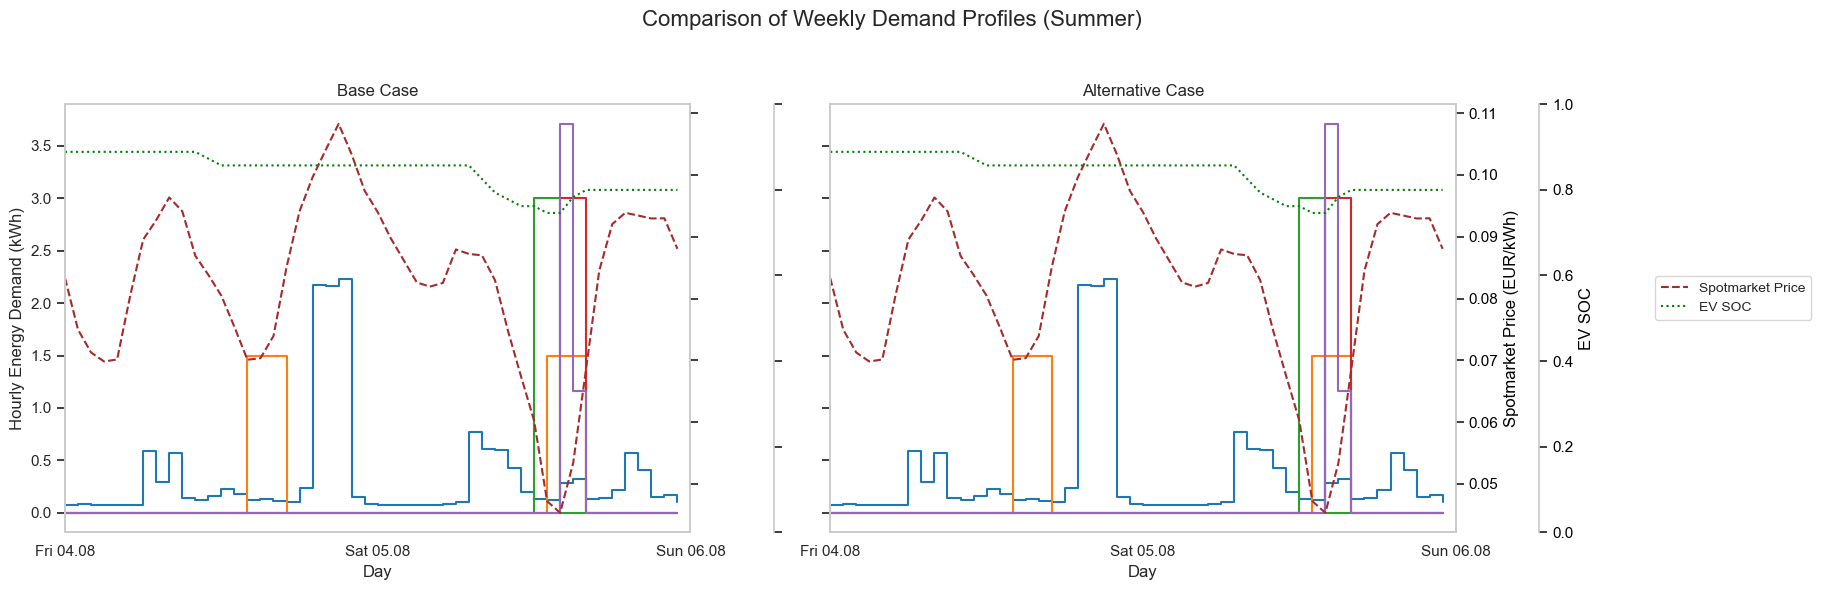

In [61]:

plot_energy_profiles_comparison(
    results_list=[results_basecase_summer, results_basecase_summer],
    titles="Comparison of Weekly Demand Profiles (Summer)",
    labels=["Base Case", "Alternative Case"],
    save_filename="summer_comparison.png",
    min_time=24*3,
    max_time=24*5
)